In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm
from sklearn import metrics
from scipy import stats as stat
from ggplot import *
import statsmodels.formula.api as smf

In [2]:
# Import train and test data
datatbl = pd.read_csv('Classification_Problem.csv')
#datatbl

In [3]:
# Missing Value Summary
print(datatbl.isnull().sum(axis=1).sum())
print(datatbl.isnull().sum()) # Variable-wise missing value
# No Missing value

0
Response    0
Var1        0
Var2        0
Var3        0
dtype: int64


(array([  1.,   3.,  16.,  28.,  51.,  75.,  82.,  65.,  44.,  35.]), array([ 220.,  278.,  336.,  394.,  452.,  510.,  568.,  626.,  684.,
        742.,  800.]), <a list of 10 Patch objects>)


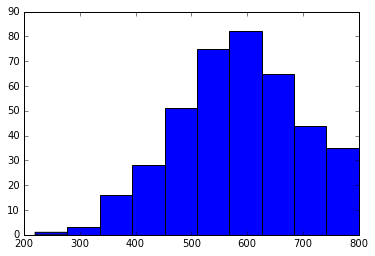

In [4]:
print(plt.hist(datatbl['Var1']))

(array([  3.,   4.,  16.,  34.,  42.,  57.,  76.,  66.,  39.,  63.]), array([ 2.26 ,  2.434,  2.608,  2.782,  2.956,  3.13 ,  3.304,  3.478,
        3.652,  3.826,  4.   ]), <a list of 10 Patch objects>)


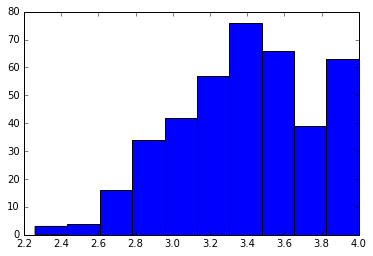

In [5]:
print(plt.hist(datatbl['Var2']))

(array([  61.,    0.,    0.,  151.,    0.,    0.,  121.,    0.,    0.,   67.]), array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ]), <a list of 10 Patch objects>)


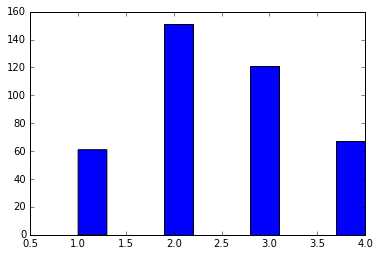

In [6]:
print(plt.hist(datatbl['Var3']))

In [7]:
print(datatbl['Response'].value_counts())
print(datatbl['Response'].value_counts(normalize=True))

0    273
1    127
Name: Response, dtype: int64
0    0.6825
1    0.3175
Name: Response, dtype: float64


In [8]:
pd.crosstab(datatbl['Response'],datatbl['Var3'])

Var3,1,2,3,4
Response,,,,
0,28,97,93,55
1,33,54,28,12


In [9]:
pd.crosstab(datatbl['Response'],datatbl['Var3']).apply(lambda r: r/r.sum(),axis=0)

Var3,1,2,3,4
Response,,,,
0,0.459016,0.642384,0.768595,0.820896
1,0.540984,0.357616,0.231405,0.179104


In [10]:
Var3_Dummy = pd.get_dummies(datatbl['Var3'], prefix = 'Var3')
datatbl = pd.concat([datatbl, Var3_Dummy], axis=1)

In [11]:
# Removing Outliers; 
# Removing values which lie beyond (+/-) 3 X Standard Deviation
# Step1: Getting the outliers
print(datatbl.shape) # Initial data size
outlier1 = datatbl[~(np.abs(datatbl.Var1-datatbl.Var1.mean())<=(3*datatbl.Var1.std()))] 
outlier2 = datatbl[~(np.abs(datatbl.Var2-datatbl.Var2.mean())<=(3*datatbl.Var2.std()))]

print(outlier1)
print(outlier2)

# Step2: Removing from main data
datatbl_outlier_treated = datatbl[~(datatbl.Var1.isin(outlier1.Var1))]
print(datatbl_outlier_treated.shape)

(400, 8)
     Response  Var1  Var2  Var3  Var3_1  Var3_2  Var3_3  Var3_4
304         0   220  2.83     3     0.0     0.0     1.0     0.0
Empty DataFrame
Columns: [Response, Var1, Var2, Var3, Var3_1, Var3_2, Var3_3, Var3_4]
Index: []
(399, 8)


In [12]:
# Resetting index
final_data_reset = datatbl_outlier_treated.reset_index().drop(['index'], axis = 1)
print(final_data_reset.shape)
final_data = final_data_reset
#final_data

(399, 8)


In [13]:
# Splitting into Train and Test data in 70:30 ratio with a stratified sampling
y=final_data.Response
x=final_data[['Var1', 'Var2', 'Var3','Var3_1', 'Var3_2', 'Var3_3', 'Var3_4']]
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=5,test_size = 0.3, stratify=y)

In [14]:
train = pd.concat([y_train, x_train], axis=1).reset_index().drop(['index'], axis = 1)
test = pd.concat([y_test, x_test], axis=1).reset_index().drop(['index'], axis = 1)

In [15]:
#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome, testdata):        
        
    #Fit the model:
    model.fit(data[predictors],data[outcome])
    
    #THE FOLLOWING CODE CALCULATES THE ESTIMATES OF COEFFICIENTS
    def MLE_coefficient():
        if name_model in ['LinearSVC','LogisticRegression']:           
            Coefficient = pd.DataFrame(model.coef_.tolist()).transpose()
            Intercept = pd.DataFrame(model.intercept_)
            Variable = Intercept.append(Coefficient, ignore_index=True)
            df1= pd.DataFrame(['Intercept'])
            df2 = pd.DataFrame(predictors)
            Predictor = df1.append(df2, ignore_index=True)
            MLE = pd.merge(Predictor, Variable, how='inner', left_index=True, right_index=True)
            MLE = pd.merge(Predictor, Variable, how='inner', left_index=True, right_index=True)
            MLE.columns = ['Independent_Variables','Beta_Values']
            print('\nMaximum Likelihood Estimator Table: \n==================================== \n', MLE)
        elif name_model in ['RandomForestClassifier','DecisionTreeClassifier']:
            Variable = pd.DataFrame(model.feature_importances_.tolist())
            Predictor = pd.DataFrame(predictors)
            MLE = pd.merge(Predictor, Variable, how='inner', left_index=True, right_index=True)
            MLE.columns = ['Independent_Variables','Feature_Importance']
            print('\nFeature Importance Table: \n==================================== \n', MLE)
 
    #THE FOLLOWING CODE CALCULATES CONCORDANCE AND DISCORDANCE
    def concordance_discordance():
        Probability = model.predict_proba(data[predictors])
        Probability1 = pd.DataFrame(Probability)
        Probability1.columns = ['Prob_0','Prob_1']
        TruthTable = pd.merge(data[[outcome]], Probability1[['Prob_1']], how='inner', left_index=True, right_index=True)
        zeros = TruthTable[(TruthTable[outcome]==0)].reset_index().drop(['index'], axis = 1)
        ones = TruthTable[(TruthTable[outcome]==1)].reset_index().drop(['index'], axis = 1)
        from bisect import bisect_left, bisect_right
        zeros_list = sorted([zeros.iloc[j,1] for j in zeros.index])
        zeros_length = len(zeros_list)
        disc = 0
        ties = 0
        conc = 0
        for i in ones.index:
            cur_conc = bisect_left(zeros_list, ones.iloc[i,1])
            cur_ties = bisect_right(zeros_list, ones.iloc[i,1]) - cur_conc
            conc += cur_conc
            ties += cur_ties
        pairs_tested = zeros_length * len(ones.index)
        disc = pairs_tested - conc - ties
        print("Pairs = ", pairs_tested)
        print("Conc = ", conc)
        print("Disc = ", disc)
        print("Tied = ", ties)
        concordance = round(conc/pairs_tested,2)
        discordance = round(disc/pairs_tested,2)
        ties_perc = round(ties/pairs_tested,2)
        Somers_D = round((conc - disc)/pairs_tested,2)
        print("Concordance = ", concordance, "%")
        print("Discordance = ", discordance, "%")
        print("Tied = ", ties_perc, "%")
        print("Somers D = ", Somers_D)
    
    #THE FOLLOWING CODE GIVES OUT THE CLASSIFICATION TABLE TO DETERMINE P BASED ON ROC CURVE
    def classification_table_func():
        Probability = model.predict_proba(data[predictors])
        Probability1 = pd.DataFrame(Probability)
        Probability1.columns = ['Prob_0','Prob_1']
        prob_min = round(Probability1.Prob_1.min() + 0.01,2)
        prob_max = round(Probability1.Prob_1.max() - 0.01,2)
        prob_val = np.arange(prob_min, prob_max, 0.01).tolist()
        ROC = []
        CT = []
        for p in prob_val:
            TruthTable = pd.merge(data[[outcome]], Probability1, how='inner', left_index=True, right_index=True)
            TruthTable.ix[TruthTable['Prob_1'] > p, 'Predicted'] = 1
            TruthTable.ix[TruthTable['Prob_1'] <= p, 'Predicted'] = 0
            Freq = pd.crosstab(TruthTable[outcome],TruthTable['Predicted'])
            TN = Freq.iloc[0,0]
            FN = Freq.iloc[1,0]
            FP = Freq.iloc[0,1]
            TP = Freq.iloc[1,1]
            Precision = TP/(TP + FP)
            Recall = TP/(TP + FN)
            F_measure = stat.hmean([ Precision,Recall])
            Specificity = TN/(TN + FP)
            Specificity_Inv = 1 - Specificity
            Sensitivity = Recall
            ROC.append({'V1_Prob': p, 'V2_Specificity_Inverse': Specificity_Inv, 'V3_Sensitivity': Sensitivity })
            CT.append({'V1_Prob': p, 'V2_Precision': Precision, 'V3_Recall': Recall, 'V4_F_Measure': F_measure })
        ROC_data = pd.DataFrame(ROC)
        FPR = ROC_data.V2_Specificity_Inverse
        TPR = ROC_data.V3_Sensitivity
        Classification_Table = pd.DataFrame(CT)
        #print('\nClassification Table: \n=============================== \n', Classification_Table)
        global threshold_prob
        threshold_prob = Classification_Table.iloc[Classification_Table['V4_F_Measure'].argmax(),0]
        print('\nThreshold Probability Value: \t', threshold_prob)
        #THE FOLLOWING CODE CREATES THE FREQUENCY TABLE FOR RECALL AND PRECISION CALCULATION
        def frequency_table(prob):
            TruthTable = pd.merge(data[[outcome]], Probability1, how='inner', left_index=True, right_index=True)
            TruthTable.ix[TruthTable['Prob_1'] > prob, 'Predicted'] = 1
            TruthTable.ix[TruthTable['Prob_1'] <= prob, 'Predicted'] = 0
            Freq = pd.crosstab(TruthTable[outcome],TruthTable['Predicted'])
            TN = Freq.iloc[0,0]
            FN = Freq.iloc[1,0]
            FP = Freq.iloc[0,1]
            TP = Freq.iloc[1,1]
            Precision = TP/(TP + FP)
            Recall = TP/(TP + FN)
            F_measure = stat.hmean([ Precision,Recall])
            Correct_Identification = TN + TP
            Obs_Count = Freq[0].sum() + Freq[1].sum()
            Accuracy = Correct_Identification/Obs_Count
            print('\n==================================================')
            print('Accuracy (Using Precision-Recall and F-Measure):')
            print('==================================================')
            print('In-Sample Accuracy: \n=======================================')
            print('\nFrequency Table: \n===============================\n', Freq)
            print('\nAccuracy: %s'% "{0:.3%}".format(Accuracy))
            print('Precision: %s'% "{0:.3%}".format(Precision))
            print('Recall: %s' % "{0:.3%}".format(Recall))
            print('F-Measure: %s'% "{0:.3%}".format(F_measure))
            #print('\nFrequency Table (Percentage): \n=============================== \n', pd.crosstab(TruthTable[outcome],TruthTable['Predicted']).apply(lambda r: r/Obs_Count))
            #print('\nFrequency Table (Percentage of Actual Totals): \n=============================== \n', pd.crosstab(TruthTable[outcome],TruthTable['Predicted']).apply(lambda r: r/r.sum(), axis=1))
            #print('\nFrequency Table (Percentage of Predicted Totals): \n=============================== \n', pd.crosstab(TruthTable[outcome],TruthTable['Predicted']).apply(lambda r: r/r.sum(), axis=0))      
        frequency_table(threshold_prob)
        
        
    #THE FOLLOWING CODE GIVES OUT THE CLASSIFICATION TABLE TO DETERMINE P BASED ON ROC CURVE
    def cross_validation():
        classification_table_func()
        Probability = model.predict_proba(testdata[predictors])
        Probability1 = pd.DataFrame(Probability)
        Probability1.columns = ['Prob_0','Prob_1']

        #THE FOLLOWING CODE CREATES THE FREQUENCY TABLE FOR RECALL AND PRECISION CALCULATION
        def frequency_table(prob):
            TruthTable = pd.merge(testdata[[outcome]], Probability1, how='inner', left_index=True, right_index=True)
            TruthTable.ix[TruthTable['Prob_1'] > prob, 'Predicted'] = 1
            TruthTable.ix[TruthTable['Prob_1'] <= prob, 'Predicted'] = 0
            Freq = pd.crosstab(TruthTable[outcome],TruthTable['Predicted'])
            TN = Freq.iloc[0,0]
            FN = Freq.iloc[1,0]
            FP = Freq.iloc[0,1]
            TP = Freq.iloc[1,1]
            Precision = TP/(TP + FP)
            Recall = TP/(TP + FN)
            F_measure = stat.hmean([ Precision,Recall])
            Correct_Identification = TN + TP
            Obs_Count = Freq[0].sum() + Freq[1].sum()
            Accuracy = Correct_Identification/Obs_Count
            print('\nOut-of-Sample Accuracy: \n=======================================')
            print('\nFrequency Table: \n===============================\n', Freq)
            print('\nAccuracy: %s' % "{0:.3%}".format(Accuracy))
            print('Precision: %s'% "{0:.3%}".format(Precision))
            print('Recall: %s'% "{0:.3%}".format( Recall))
            print('F-Measure: %s'% "{0:.3%}".format( F_measure))
            #print('\nFrequency Table (Percentage): \n=============================== \n', pd.crosstab(TruthTable[outcome],TruthTable['Predicted']).apply(lambda r: r/Obs_Count))    
        frequency_table(threshold_prob)
    
    def validation():
        
        error = []
        accuracy = []
        print('\n==================================================')
        print('Accuracy (Using inbuilt "accuracy_score" function):')
        print('================================================== \n')
        
        model.fit(data[predictors],data[outcome])
        error = (model.score(data[predictors], data[outcome]))
        predictions = model.predict(data[predictors])
        accuracy = (metrics.accuracy_score(predictions,data[outcome]))
        print ("In-Sample Accuracy: %s" % "{0:.3%}".format(accuracy))                    
        
        
        error = []
        accuracy = []        
        error = (model.score(testdata[predictors], testdata[outcome]))
        predictions = model.predict(testdata[predictors])
        accuracy = (metrics.accuracy_score(predictions,testdata[outcome]))
        print ("Out-of-Sample Accuracy: %s" % "{0:.3%}".format(accuracy))                    
    
    name_model = str(ascii(repr(model))).replace('"','').split('(')[0]
    print(name_model)
    MLlist = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier' ,'SVC', 'LinearSVC']
    
    if name_model == 'LogisticRegression':
        MLE_coefficient()
        concordance_discordance()
        cross_validation()
        validation()
        
    elif name_model == 'DecisionTreeClassifier':
        #MLE_coefficient()
        concordance_discordance()
        cross_validation()
        validation()
        
    elif name_model == 'RandomForestClassifier':
        MLE_coefficient()
        concordance_discordance()
        cross_validation()
        validation()
        
    elif name_model == 'SVC':
        #MLE_coefficient()
        concordance_discordance()
        cross_validation()
        validation()

    elif name_model == 'LinearSVC':
        MLE_coefficient()
        #concordance_discordance()
        #cross_validation()
        validation()

   
    #print(pd.DataFrame(model.intercept_))
    #MLE_coefficient()
    #Fit the model again so that it can be refered outside the function:
    #model.fit(data[predictors],data[outcome]) 

In [16]:
#We can try different combination of variables:
outcome_var = 'Response'
predictor_var = ['Var1','Var2','Var3_2','Var3_3','Var3_4']
#predictor_var = ['Var2','Var3_2','Var3_3','Var3_4']
model = LogisticRegression()
classification_model(model,train,predictor_var,outcome_var,test)

LogisticRegression

Maximum Likelihood Estimator Table: 
   Independent_Variables  Beta_Values
0             Intercept    -0.715295
1                  Var1     0.000267
2                  Var2     0.192598
3                Var3_2    -0.579754
4                Var3_3    -1.251851
5                Var3_4    -1.628559
Pairs =  16910
Conc =  11679
Disc =  5228
Tied =  3
Concordance =  0.69 %
Discordance =  0.31 %
Tied =  0.0 %
Somers D =  0.38

Threshold Probability Value: 	 0.37

Accuracy (Using Precision-Recall and F-Measure):
In-Sample Accuracy: 

Frequency Table: 
 Predicted  0.0  1.0
Response           
0          130   60
1           32   57

Accuracy: 67.025%
Precision: 48.718%
Recall: 64.045%
F-Measure: 55.340%

Out-of-Sample Accuracy: 

Frequency Table: 
 Predicted  0.0  1.0
Response           
0           54   28
1           16   22

Accuracy: 63.333%
Precision: 44.000%
Recall: 57.895%
F-Measure: 50.000%

Accuracy (Using inbuilt "accuracy_score" function):

In-Sample Accuracy: 70

In [17]:
#We can try different combination of variables:
outcome_var = 'Response'
predictor_var = ['Var1','Var2','Var3_2','Var3_3','Var3_4']
model = DecisionTreeClassifier()
classification_model(model,train,predictor_var,outcome_var,test)

DecisionTreeClassifier
Pairs =  16910
Conc =  16901
Disc =  0
Tied =  9
Concordance =  1.0 %
Discordance =  0.0 %
Tied =  0.0 %
Somers D =  1.0

Threshold Probability Value: 	 0.01

Accuracy (Using Precision-Recall and F-Measure):
In-Sample Accuracy: 

Frequency Table: 
 Predicted  0.0  1.0
Response           
0          187    3
1            0   89

Accuracy: 98.925%
Precision: 96.739%
Recall: 100.000%
F-Measure: 98.343%

Out-of-Sample Accuracy: 

Frequency Table: 
 Predicted  0.0  1.0
Response           
0           63   19
1           22   16

Accuracy: 65.833%
Precision: 45.714%
Recall: 42.105%
F-Measure: 43.836%

Accuracy (Using inbuilt "accuracy_score" function):

In-Sample Accuracy: 98.925%
Out-of-Sample Accuracy: 65.833%


In [18]:
#We can try different combination of variables:
outcome_var = 'Response'
predictor_var = ['Var1','Var2','Var3_2','Var3_3','Var3_4']
#predictor_var = ['Var2','Var3_2','Var3_3','Var3_4']
model = RandomForestClassifier(n_estimators=10)
classification_model(model,train,predictor_var,outcome_var,test)

RandomForestClassifier

Feature Importance Table: 
   Independent_Variables  Feature_Importance
0                  Var1            0.398570
1                  Var2            0.492611
2                Var3_2            0.037637
3                Var3_3            0.029844
4                Var3_4            0.041338
Pairs =  16910
Conc =  16714
Disc =  102
Tied =  94
Concordance =  0.99 %
Discordance =  0.01 %
Tied =  0.01 %
Somers D =  0.98

Threshold Probability Value: 	 0.5

Accuracy (Using Precision-Recall and F-Measure):
In-Sample Accuracy: 

Frequency Table: 
 Predicted  0.0  1.0
Response           
0          187    3
1           10   79

Accuracy: 95.341%
Precision: 96.341%
Recall: 88.764%
F-Measure: 92.398%

Out-of-Sample Accuracy: 

Frequency Table: 
 Predicted  0.0  1.0
Response           
0           64   18
1           26   12

Accuracy: 63.333%
Precision: 40.000%
Recall: 31.579%
F-Measure: 35.294%

Accuracy (Using inbuilt "accuracy_score" function):

In-Sample Accuracy: 97.

In [19]:
#We can try different combination of variables:
outcome_var = 'Response'
predictor_var = ['Var1','Var2','Var3_2','Var3_3','Var3_4']
#predictor_var = ['Var2','Var3_2','Var3_3','Var3_4']
#model = svm.SVC(probability=True, C=10.0, gamma='auto', kernel='rbf')
#model = svm.SVC(probability=True, C=1.0, gamma='auto', kernel='rbf')
model = svm.SVC(probability=True, C=0.1, gamma='auto', kernel='rbf')
#model = svm.LinearSVC(C=10.0)
classification_model(model,train,predictor_var,outcome_var,test)

SVC
Pairs =  16910
Conc =  14209
Disc =  2698
Tied =  3
Concordance =  0.84 %
Discordance =  0.16 %
Tied =  0.0 %
Somers D =  0.68

Threshold Probability Value: 	 0.31

Accuracy (Using Precision-Recall and F-Measure):
In-Sample Accuracy: 

Frequency Table: 
 Predicted  0.0  1.0
Response           
0          147   43
1           18   71

Accuracy: 78.136%
Precision: 62.281%
Recall: 79.775%
F-Measure: 69.951%

Out-of-Sample Accuracy: 

Frequency Table: 
 Predicted  0.0  1.0
Response           
0           38   44
1           20   18

Accuracy: 46.667%
Precision: 29.032%
Recall: 47.368%
F-Measure: 36.000%

Accuracy (Using inbuilt "accuracy_score" function):

In-Sample Accuracy: 68.100%
Out-of-Sample Accuracy: 68.333%


In [22]:
test.head(2)

,Response,Var1,Var2,Var3,Var3_1,Var3_2,Var3_3,Var3_4
0,1,800,3.74,1,1.0,0.0,0.0,0.0
1,0,500,3.88,4,0.0,0.0,0.0,1.0


In [23]:
new_customer = [{'Var1': 700, 'Var2': 4, 'Var3': 1, 'Var3_1': 1, 'Var3_2': 0, 'Var3_3': 0, 'Var3_4': 0}]
problem_c = pd.DataFrame(new_customer)
problem_c

,Var1,Var2,Var3,Var3_1,Var3_2,Var3_3,Var3_4
0,700,4,1,1,0,0,0


In [44]:
#Generic function for making a classification model and accessing performance:
def run_one_instance(model, data, predictors, outcome, testdata):        
        
    #Fit the model:
    model.fit(data[predictors],data[outcome])
    probs = model.predict_proba(testdata[predictors])
    predictions = model.predict(testdata[predictors])
    return probs, predictions


In [47]:
#We can try different combination of variables:
outcome_var = 'Response'
predictor_var = ['Var1','Var2','Var3_2','Var3_3','Var3_4']
model = LogisticRegression()
#model = RandomForestClassifier(n_estimators=10)
#model = svm.SVC(probability=True, C=0.1, gamma='auto', kernel='rbf')
run_one_instance(model,train,predictor_var,outcome_var,problem_c)

(array([[ 0.43987198,  0.56012802]]), array([1]))